In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from __future__ import print_function, division
import numpy as np


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = False
    session = tf.Session(config=config)
    return session

In [51]:
import tensorflow as tf
from functools import partial
from tensorflow.examples.tutorials.mnist import input_data
mnist= input_data.read_data_sets("/tmp/data/", one_hot=True)
#10 clasees, 0-9

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [52]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [53]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
#        x = tf.cast(x,dtype=tf.float64)
#        inp_shape = tf.cast(x.shape[1],tf.int64)
#        W1 = tf.Variable(tf.random_normal(shape=(inp_shape,256),dtype=tf.float64),dtype=tf.float64)
#        b1 = tf.Variable(tf.ones(shape=(W1.shape[1]),dtype=tf.float64))
#        W2 = tf.Variable(tf.random_normal(shape=(256,256),dtype=tf.float64),dtype=tf.float64)
#        b2 = tf.Variable(tf.ones(shape=(W1.shape[1]),dtype=tf.float64))
#        W3 = tf.Variable(tf.random_normal(shape=(256,1),dtype=tf.float64),dtype=tf.float64)
#        b3 = tf.Variable(tf.ones(shape=(W3.shape[1]),dtype=tf.float64))
#        h1 = leaky_relu(tf.matmul(x,W1)+b1)
#        h2 = leaky_relu(tf.matmul(h1,W2)+b2)
#        h3 = tf.matmul(h2,W3)+b3
#        logits = h3
#

        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs=x,units=256,activation=partial(tf.nn.leaky_relu, alpha=0.01),kernel_initializer=init,name='1-Layer',use_bias=True)
        h2 = tf.layers.dense(inputs=h1,units=256,activation=partial(tf.nn.leaky_relu, alpha=0.01),kernel_initializer=init,name='2-Layer',use_bias=True)
        logits = tf.layers.dense(inputs=h2,units=1,kernel_initializer=init,name='3-Layer',use_bias=True)
        
        return logits

In [54]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture

        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,kernel_initializer=init,name='1-Layer',use_bias=True)
        h2 = tf.layers.dense(inputs=h1,units=1024,activation=tf.nn.relu,kernel_initializer=init,name='2-Layer',use_bias=True)
        img = tf.layers.dense(inputs=h2,units=784,activation=tf.nn.tanh,kernel_initializer=init,name='3-Layer',use_bias=True)         

        return img

In [55]:
def sample_noise(batch_size, dim):
    return tf.random_uniform(shape=(batch_size,dim),minval=-1,maxval=1)

In [56]:
def gan_loss(logits_real,logits_fake):
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real))+tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),logits=logits_fake))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),logits=logits_fake))
    return D_loss, G_loss

In [57]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    return D_solver, G_solver

~~~
with tf.variable_scope("") as scope:
~~~
this helps to update those variables with the weights of the network whenever those are called

In [58]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size,noise_dim)

In [59]:
G_sample = generator(z)

In [60]:
with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

In [61]:
# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

In [62]:
# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

In [63]:
# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [64]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

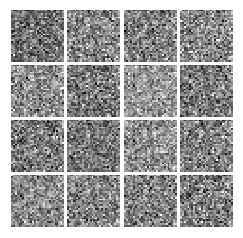


Iter: 0, D: 1.408, G:0.6713
Iter: 50, D: 0.4836, G:1.753
Iter: 100, D: 1.623, G:2.434
Iter: 150, D: 1.096, G:1.67
Iter: 200, D: 0.7785, G:1.818


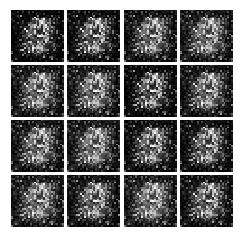


Iter: 250, D: 1.077, G:1.526
Iter: 300, D: 0.7689, G:2.01
Iter: 350, D: 1.154, G:1.245
Iter: 400, D: 1.263, G:1.316
Iter: 450, D: 1.19, G:0.9893


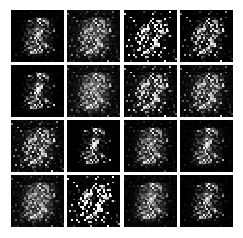


Iter: 500, D: 1.18, G:0.9387
Iter: 550, D: 1.257, G:1.179
Iter: 600, D: 1.446, G:2.035
Iter: 650, D: 1.159, G:1.148
Iter: 700, D: 1.24, G:0.9339


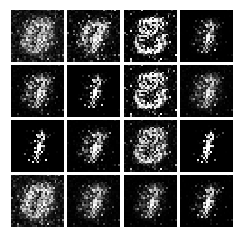


Iter: 750, D: 1.369, G:1.043
Iter: 800, D: 1.222, G:1.495
Iter: 850, D: 1.66, G:0.7149
Iter: 900, D: 1.491, G:1.373
Iter: 950, D: 1.457, G:1.041


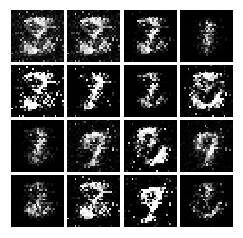


Iter: 1000, D: 1.283, G:0.7628
Iter: 1050, D: 1.136, G:1.155
Iter: 1100, D: 1.331, G:0.8739
Iter: 1150, D: 1.305, G:0.9849
Iter: 1200, D: 1.195, G:1.043


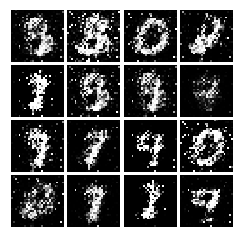


Iter: 1250, D: 1.347, G:1.002
Iter: 1300, D: 1.289, G:1.065
Iter: 1350, D: 1.15, G:1.156
Iter: 1400, D: 1.268, G:1.036
Iter: 1450, D: 1.2, G:0.9529


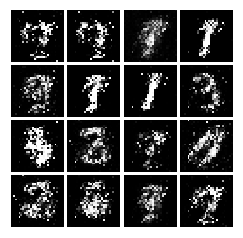


Iter: 1500, D: 1.221, G:1.199
Iter: 1550, D: 1.371, G:0.6914
Iter: 1600, D: 1.314, G:0.9305
Iter: 1650, D: 1.017, G:0.6688
Iter: 1700, D: 1.274, G:0.995


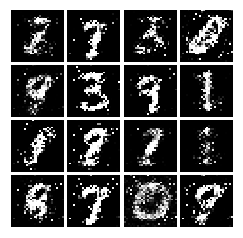


Iter: 1750, D: 1.322, G:0.9461
Iter: 1800, D: 1.326, G:0.8504
Iter: 1850, D: 1.238, G:0.8332
Iter: 1900, D: 1.267, G:0.9743
Iter: 1950, D: 1.307, G:1.777


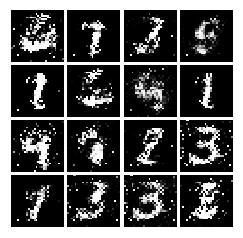


Iter: 2000, D: 1.281, G:0.9452
Iter: 2050, D: 1.31, G:0.8551
Iter: 2100, D: 1.221, G:0.867
Iter: 2150, D: 1.266, G:0.7945
Iter: 2200, D: 1.243, G:0.8402


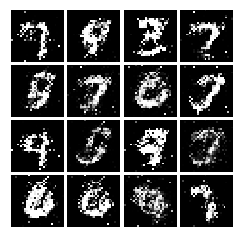


Iter: 2250, D: 1.297, G:0.7363
Iter: 2300, D: 1.251, G:0.9174
Iter: 2350, D: 1.217, G:0.8354
Iter: 2400, D: 1.24, G:0.7355
Iter: 2450, D: 1.272, G:0.8103


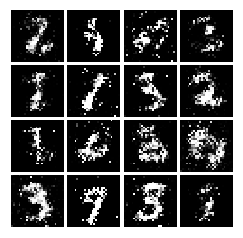


Iter: 2500, D: 1.257, G:0.8738
Iter: 2550, D: 1.353, G:1.039
Iter: 2600, D: 1.195, G:0.9571
Iter: 2650, D: 1.356, G:0.7788
Iter: 2700, D: 1.264, G:0.8362


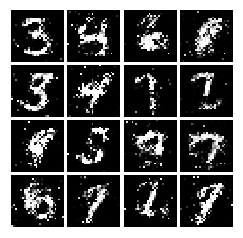


Iter: 2750, D: 1.271, G:0.7664
Iter: 2800, D: 1.382, G:0.9316
Iter: 2850, D: 1.318, G:0.867
Iter: 2900, D: 1.319, G:0.8207
Iter: 2950, D: 1.321, G:0.7931


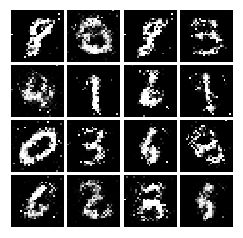


Iter: 3000, D: 1.381, G:0.7189
Iter: 3050, D: 1.363, G:0.7847
Iter: 3100, D: 1.342, G:0.8056
Iter: 3150, D: 1.308, G:0.8257
Iter: 3200, D: 1.621, G:1.04


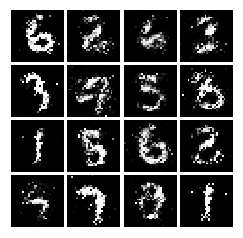


Iter: 3250, D: 1.354, G:1.832
Iter: 3300, D: 1.303, G:0.8459
Iter: 3350, D: 1.336, G:0.8197
Iter: 3400, D: 1.299, G:0.8395
Iter: 3450, D: 1.314, G:0.81


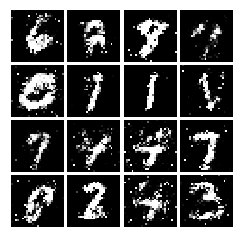


Iter: 3500, D: 1.337, G:0.8466
Iter: 3550, D: 1.349, G:0.8332
Iter: 3600, D: 1.356, G:0.8944
Iter: 3650, D: 1.265, G:0.842
Iter: 3700, D: 1.379, G:0.7961


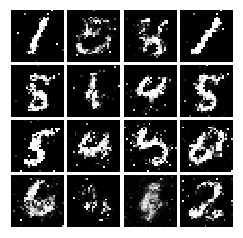


Iter: 3750, D: 1.279, G:0.7462
Iter: 3800, D: 1.3, G:0.8128
Iter: 3850, D: 1.382, G:0.8407
Iter: 3900, D: 1.308, G:0.8336
Iter: 3950, D: 1.365, G:0.7343


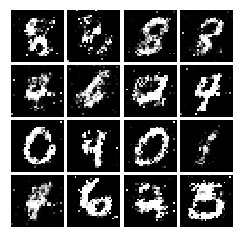


Iter: 4000, D: 1.317, G:0.8214
Iter: 4050, D: 1.311, G:0.853
Iter: 4100, D: 1.293, G:0.7686
Iter: 4150, D: 1.301, G:0.8703
Iter: 4200, D: 1.314, G:0.8088


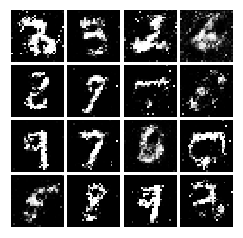


Iter: 4250, D: 1.345, G:0.8421
Final images


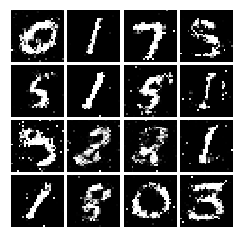

ValueError: Variable generator/1-Layer/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-54-766e702bf2f4>", line 14, in generator
    h1 = tf.layers.dense(inputs=z,units=1024,activation=tf.nn.relu,kernel_initializer=init,name='1-Layer',use_bias=True)
  File "<ipython-input-59-4be9d9bb57b6>", line 1, in <module>
    G_sample = generator(z)
  File "/home/legion/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [67]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)